In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import optax
import jax
import jax.numpy as jnp
import pennylane as qml

#numpy precisa estar em 1.23 (o problema foi que o optax mudou a versão do numpy)

In [2]:
H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)

  (1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


In [3]:
dev = qml.device('default.qubit', wires=2)

t = 1
n = 2

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit, expansion_strategy='device')())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


In [4]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

# @qml.qnode(dev)
# def circuit(param):
#     circ(param)
#     return [qml.expval(qml.PauliZ(i)) for i in range(2)]

# print(qml.draw(circuit)(0.5))

In [5]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


In [6]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

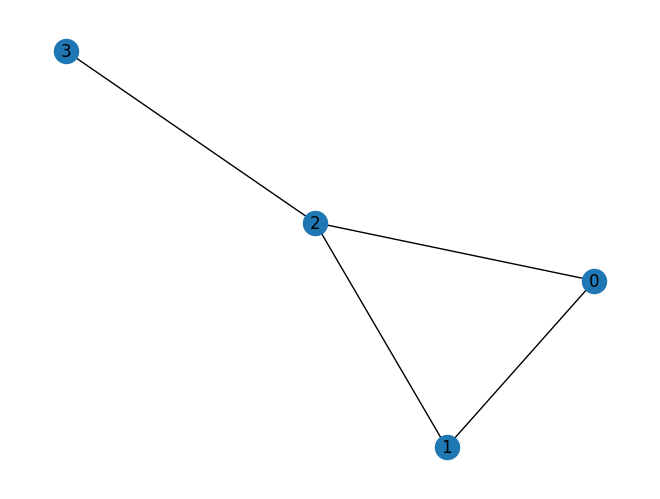

In [7]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [8]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [9]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [10]:
# Circuito principal

wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [11]:
dev = qml.device("qulacs.simulator", wires=wires)   #adicionar gpu=True
# precisa instalar o qulacs:  pip install qulacs

@qml.qnode(dev, interface="jax")   # @qml.qnode(dev, interface = "jax")
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [12]:
optimizer = optax.adam(learning_rate=0.01)
steps = 70
params = jnp.array([[0.5, 0.5], [0.5, 0.5]])

# params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [14]:
for i in range(steps):
    print(params)
    grads = jax.grad(cost_function)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    params = optimizer.step(cost_function, params)

    # loss, grads = jax.value_and_grad(cost_function)(params)
    # updates, opt_state = optimizer.update(grads, opt_state)
    # params = optax.apply_updates(params, updates)
    # params = optimizer.step(cost_function, params)

# print("Optimal Parameters")
# print(params)

[[0.5 0.5]
 [0.5 0.5]]


AttributeError: module 'jax' has no attribute 'ad'

In [ ]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

C:\Users\luccas.marim\AppData\Local\Temp\ipykernel_16560\847613202.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


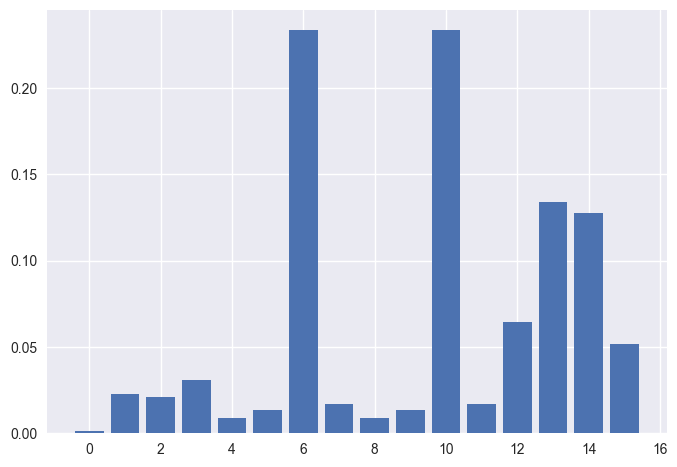

In [ ]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()